The problem (Teeth Classification) is multiclass classification

The common cost/lost function used in these problems is the categorical cross entropy

For testing, use the classification_report for ease (to contain many metrics: f1 score, recall, precision)

For multiclassification, use in the output layer softmax activation function

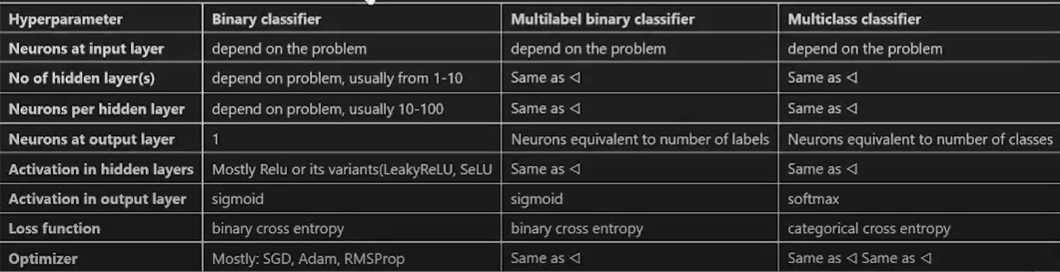

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# To avoid changing in any results --randomly
# Set the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Loading the data

In [4]:
training_dir = '/content/drive/My Drive/Teeth DataSet/Teeth_Dataset/Training'
testing_dir = '/content/drive/My Drive/Teeth DataSet/Teeth_Dataset/Testing'
validating_dir='/content/drive/My Drive/Teeth DataSet/Teeth_Dataset/Validation'

In [5]:
# Load training data
train_data_gen = ImageDataGenerator(rescale=1.0/255)
train_data = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # For multi-class classification (7 classes)
)

Found 3087 images belonging to 7 classes.


I have normalized the images (rescale pixcel values which ranges from 0 to 1)

I do not resize the images despite the higher computational power it will take, but I need a high accuracy model (specifically because it is a healthcare solution)

In this link (https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/), it is stated that the augmentation is three different types where the second type is called in-place (on_-the-fly) data augmentation which is what Keras’ ImageDataGenerator class implements, so there is no need to augment manually



Visualize the data to check its loaded

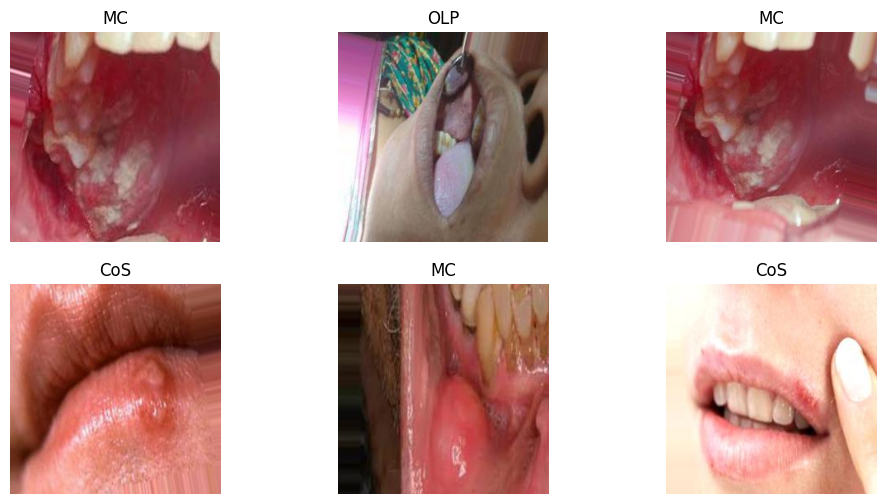

In [6]:
# Get a batch of images and labels
images, labels = next(train_data)

# Get the class names from the class_indices dictionary
class_names = list(train_data.class_indices.keys())

# Display the images and labels
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

In [6]:
# Load validating data
valid_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data = valid_data_gen.flow_from_directory(
    validating_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # For multi-class classification (7 classes)
)

Found 1028 images belonging to 7 classes.


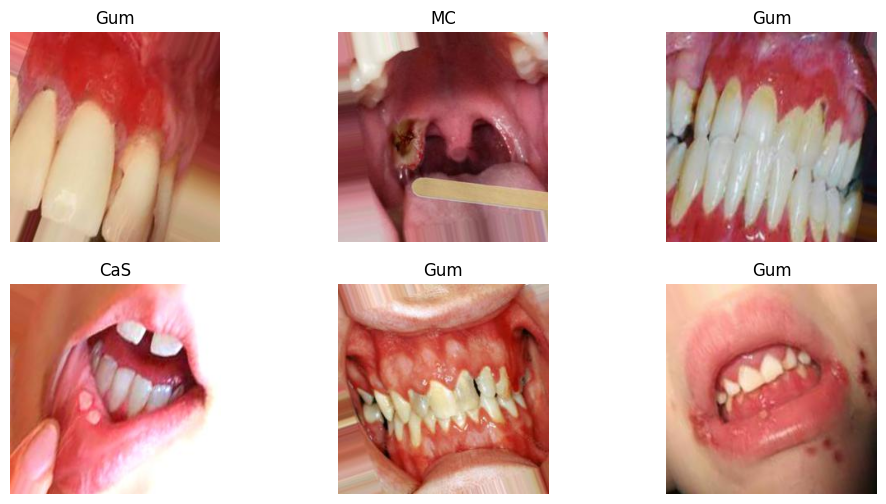

In [9]:
# Get a batch of images and labels
images, labels = next(valid_data)

# Get the class names from the class_indices dictionary
class_names = list(valid_data.class_indices.keys())

# Display the images and labels
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

Visualization

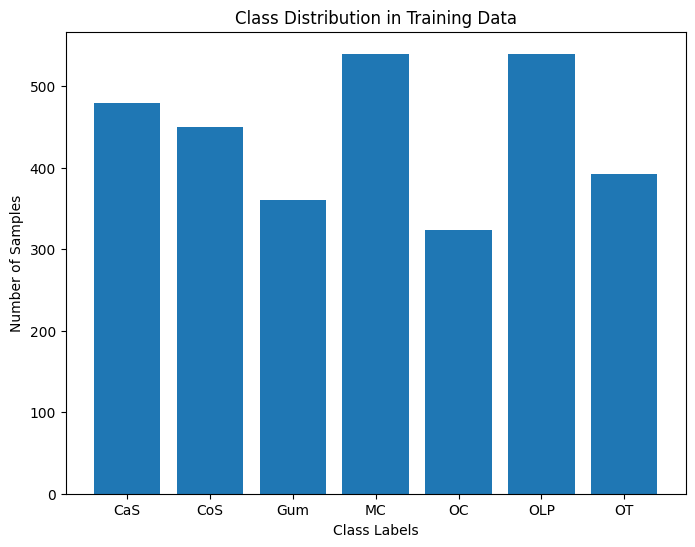

In [9]:
# Get class labels
class_labels = list(train_data.class_indices.keys())

# Calculate the count of samples per class
class_counts = np.bincount(train_data.classes)
# train_data.classes contains samples' class labels-np.bincount used to count each class's occurrences

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.show()

I think I need to augment to add some images within specifically these classes (GUM, OC, OT) because the dataset is not balanced

In [ ]:
# Define the data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the underrepresented classes
underrepresented_classes = ['Gum', 'OC', 'OT']
for class_name in underrepresented_classes:
    class_idx = train_data.class_indices[class_name]
    class_samples = [sample for sample, label in train_data if np.argmax(label) == class_idx]

    # Generate 200 additional samples for the underrepresented class
    num_additional_samples = 200
    augmented_samples = train_datagen.flow(
        np.array(class_samples),
        np.ones(len(class_samples)),
        batch_size=num_additional_samples
    )

    # Add the augmented samples to the training data generator
    train_data.next()
    train_data.class_indices[class_name] = class_idx
    train_data._set_index_array()
    train_data.file_list.extend(augmented_samples.filenames)
    train_data.classes = np.conctenate((train_data.classes, augmented_samples.classes))
    train_data.filenames.extend(augmented_samples.filenames)
    train_data.samples += num_additional_samples

The session crash because of the RAM is out of storage (even when I made it only 20 samples for each class)

Trying jupyter notebook when installing tensorflow, it gives me: PermissionError: [WinError 5] Access is denied

In [13]:
# Load test data
test_data_gen = ImageDataGenerator(rescale=1.0/255)
test_data = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # For multi-class classification (7 classes)
)

Found 1028 images belonging to 7 classes.


I do not understand what these directories mean/represent (outputs, out,output_image) so, I deleted them

Model Building

In [25]:
# Creating a model
TDisease_classifier = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),  # Flattening layer
    tf.keras.layers.Dense(units=64, activation='relu'),  # First dense layer
    tf.keras.layers.Dense(units=32, activation='relu'),  # Second dense layer
    tf.keras.layers.Dense(units=7, activation='softmax')  # Output layer
])


TDisease_classifier.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

TDisease_classifier.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
TDisease_classifier2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

TDisease_classifier2.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

TDisease_classifier2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,510,471 (120.20 MB)

 Trainable params: 31,510,471 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

Data Generators: using a ImageDataGenerator, it handles providing both images and corresponding labels in batches during the fit() process --no need to explicitly pass the labels as a separate argument

In [10]:
TDisease_classifier.fit(train_data, epochs=40, validation_data=valid_data)

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.3720 - loss: 1.7010 - val_accuracy: 0.3346 - val_loss: 1.7492
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 404ms/step - accuracy: 0.4547 - loss: 1.4809 - val_accuracy: 0.3181 - val_loss: 1.7351
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.4443 - loss: 1.4693 - val_accuracy: 0.3249 - val_loss: 1.9235
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - accuracy: 0.4425 - loss: 1.4939 - val_accuracy: 0.2325 - val_loss: 2.1928
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 421ms/step - accuracy: 0.4210 - loss: 1.5205 - val_accuracy: 0.2519 - val_loss: 2.1281
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.3766 - loss: 1.6734 - val_accuracy: 0.3035 - val_loss: 1.7834
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.4084 - loss: 1.5250 - val_accuracy: 0.3200 - val_loss: 1.8631
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - accuracy: 0.4083 - loss: 1.5192 - val_accu

Epoch 20/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 409ms/step - accuracy: 0.4038 - loss: 1.5832 - val_accuracy: 0.3210 - val_loss: 1.7786
As I started with 20 epochs, I will increase it to increase the accuracy

CNN is the best with the images (high-dimension data) --I used it for better performence

In [10]:
TDisease_classifier2.fit(train_data, epochs=40, validation_data=valid_data)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 983s 10s/step - accuracy: 0.2230 - loss: 5.0273 - val_accuracy: 0.4222 - val_loss: 1.5297
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.5188 - loss: 1.3442 - val_accuracy: 0.5010 - val_loss: 1.3441
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.7069 - loss: 0.8745 - val_accuracy: 0.5671 - val_loss: 1.2522
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.8796 - loss: 0.3659 - val_accuracy: 0.5730 - val_loss: 1.4251
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.9777 - loss: 0.1075 - val_accuracy: 0.5837 - val_loss: 1.3757
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - accuracy: 0.9908 - loss: 0.0476 - val_accuracy: 0.6148 - val_loss: 1.5173
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.9922 - loss: 0.0356 - val_accuracy: 0.5768 - val_loss: 1.9835
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.9991 - loss: 0.0125 - val_accuracy: 0.5710 - val_loss: 2

<Axes: >

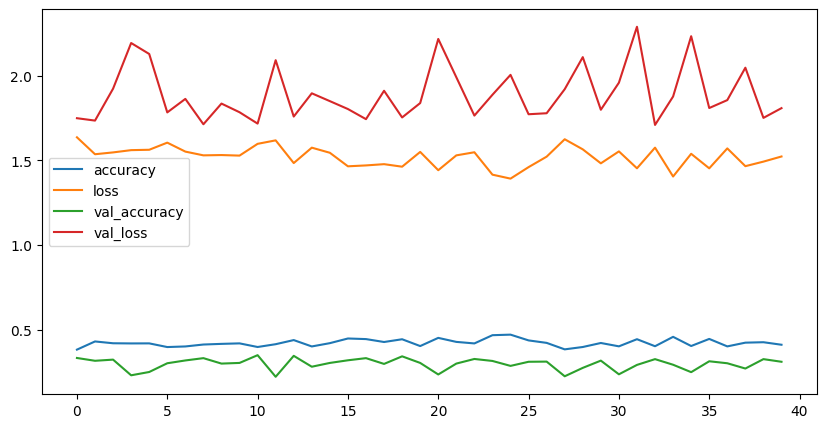

In [13]:
# Getting the dataframe of loss and accuracies on both training and validation
loss_acc_metrics_df = pd.DataFrame(TDisease_classifier.history.history)

# Plotting the loss and accuracy
loss_acc_metrics_df.plot(figsize=(10,5))

<Axes: >

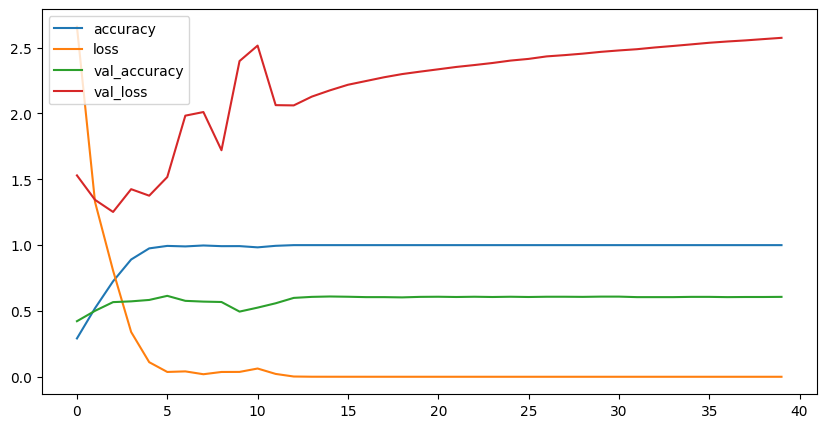

In [11]:
# Getting the dataframe of loss and accuracies on both training and validation
loss_acc_metrics_df = pd.DataFrame(TDisease_classifier2.history.history)

# Plotting the loss and accuracy
loss_acc_metrics_df.plot(figsize=(10,5))

In [26]:
import tensorflow as tf

# Force eager execution to identify the issue
tf.config.run_functions_eagerly(True)

# Evaluating the model on unseen data
eval = TDisease_classifier.evaluate(test_data)

# Printing the loss and accuracy
print("Test loss: {}\nTest accuracy: {}".format(eval[0], eval[1]))

# Deactivate eager execution (optional, depending on your needs)
tf.config.run_functions_eagerly(False)

33/33 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.1563 - loss: 2.0668
Test loss: 2.088667631149292
Test accuracy: 0.14494162797927856


In [14]:
import tensorflow as tf

# Force eager execution to identify the issue
tf.config.run_functions_eagerly(True)

# Evaluating the model on unseen data
eval = TDisease_classifier2.evaluate(test_data)

# Printing the loss and accuracy
print("Test loss: {}\nTest accuracy: {}".format(eval[0], eval[1]))

# Deactivate eager execution (optional, depending on your needs)
tf.config.run_functions_eagerly(False)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 0.6255 - loss: 2.6815
Test loss: 2.7992610931396484
Test accuracy: 0.6118677258491516
